In [8]:
%pip install torch torchvision torchaudio gradio numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
import random
import pickle
import os
from collections import Counter
import gradio as gr
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device utilisé: cuda
GPU: NVIDIA GeForce RTX 4080


In [ ]:
def load_hp_books():
    """Charge tous les livres Harry Potter et les combine en un seul texte"""
    books_dir = "Books/"
    all_text = ""
    
    for i in range(1, 8):
        file_path = f"{books_dir}HPBook{i}.txt"
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    lines = content.split('\n')
                    clean_lines = []
                    for line in lines:
                        if line.strip() and not line.startswith('"Text"@"Chapter"@"Book"'):
                            if line.startswith('"') and line.endswith('"'):
                                clean_line = line[1:-1]
                            elif line.startswith('"'):
                                clean_line = line[1:]
                            else:
                                clean_line = line
                            
                            clean_lines.append(clean_line.strip())
                    
                    clean_content = ' '.join(clean_lines)
                    all_text += clean_content + " "
                    print(f"Livre {i} chargé: {len(clean_content)} caractères")
            except Exception as e:
                print(f"Erreur lors du chargement du livre {i}: {e}")
    
    return all_text

raw_text = load_hp_books()
print(f"\nTexte total chargé: {len(raw_text)} caractères")
print(f"Aperçu: {raw_text[:200]}...")

Livre 1 chargé: 444296 caractères
Livre 2 chargé: 496523 caractères
Livre 3 chargé: 618633 caractères
Livre 4 chargé: 1117233 caractères
Livre 5 chargé: 1515465 caractères
Livre 6 chargé: 994867 caractères
Livre 7 chargé: 1137446 caractères

Texte total chargé: 6324470 caractères
Aperçu: THE BOY WHO LIVED  Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in ...


In [11]:
def preprocess_text(text):
    """Nettoie et préprocesse le texte"""
    
    text = re.sub(r'[^a-zA-Z\s\.,!?;:\'\"\-]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = text.lower()
    
    return text.strip()

processed_text = preprocess_text(raw_text)
print(f"Texte après préprocessing: {len(processed_text)} caractères")
print(f"Aperçu: {processed_text[:200]}...")

Texte après préprocessing: 6251614 caractères
Aperçu: the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you'd expect to be involved in a...


In [12]:
class TextTokenizer:
    def __init__(self, min_freq=5):
        self.min_freq = min_freq
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_size = 0
        
    def fit(self, text):
        """Crée le vocabulaire à partir du texte"""
        
        words = text.split()
        
        word_counts = Counter(words)
        
        filtered_words = [word for word, count in word_counts.items() if count >= self.min_freq]
        
        special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']
        vocab = special_tokens + sorted(filtered_words)
        
        self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx_to_word = {idx: word for idx, word in enumerate(vocab)}
        self.vocab_size = len(vocab)
        
        print(f"Vocabulaire créé: {self.vocab_size} mots")
        print(f"Mots les plus fréquents: {list(vocab[4:14])}")
        
    def encode(self, text):
        """Convertit le texte en indices"""
        words = text.split()
        return [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in words]
    
    def decode(self, indices):
        """Convertit les indices en texte"""
        return ' '.join([self.idx_to_word.get(idx, '<UNK>') for idx in indices])

tokenizer = TextTokenizer(min_freq=3)
tokenizer.fit(processed_text)

encoded_text = tokenizer.encode(processed_text)
print(f"\nTexte encodé: {len(encoded_text)} tokens")
print(f"Exemple d'encodage: {encoded_text[:20]}")
print(f"Décodage: {tokenizer.decode(encoded_text[:20])}")

Vocabulaire créé: 20098 mots
Mots les plus fréquents: ['!', '"', '"\'', '"\'and', '"\'arry,', '"\'choo', '"\'course', '"\'course,', '"\'harry', '"\'ow']

Texte encodé: 1127457 tokens
Exemple d'encodage: [17651, 3176, 19504, 10712, 11750, 1802, 11752, 6069, 12366, 12272, 7561, 13697, 5960, 19385, 13802, 18008, 15027, 17636, 17722, 19385]
Décodage: the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they were


In [13]:
class HPTextDataset(Dataset):
    def __init__(self, encoded_text, sequence_length=50):
        self.encoded_text = encoded_text
        self.sequence_length = sequence_length
        
        self.sequences = []
        self.targets = []
        
        for i in range(len(encoded_text) - sequence_length):
            seq = encoded_text[i:i + sequence_length]
            target = encoded_text[i + sequence_length]
            self.sequences.append(seq)
            self.targets.append(target)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.targets[idx])

SEQUENCE_LENGTH = 30
BATCH_SIZE = 64

dataset = HPTextDataset(encoded_text, SEQUENCE_LENGTH)
print(f"Dataset créé: {len(dataset)} échantillons")

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}")
print(f"Batches par époque: {len(train_loader)}")

Dataset créé: 1127427 échantillons
Train: 1014684, Validation: 112743
Batches par époque: 15855


In [14]:
class HPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(HPTextGenerator, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           dropout=dropout, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        
        lstm_out, hidden = self.lstm(embedded, hidden)
        
        last_output = lstm_out[:, -1, :]
        
        output = self.dropout(last_output)
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        """Initialise les états cachés"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

model = HPTextGenerator(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"Modèle créé avec {sum(p.numel() for p in model.parameters())} paramètres")
print(model)

Modèle créé avec 8659330 paramètres
HPTextGenerator(
  (embedding): Embedding(20098, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=20098, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [24]:
def generate_text(model, tokenizer, start_word, max_length=50, temperature=1.0):
    """Génère du texte à partir d'un mot de départ"""
    model.eval()
    
    start_word = start_word.lower()
    if start_word not in tokenizer.word_to_idx:
        start_word = '<UNK>'
    
    sequence = [tokenizer.word_to_idx['<PAD>']] * (SEQUENCE_LENGTH - 1) + [tokenizer.word_to_idx[start_word]]
    generated = [start_word]
    
    with torch.no_grad():
        hidden = None
        
        for _ in range(max_length - 1):
            input_seq = torch.tensor(sequence).unsqueeze(0).to(device)
            output, hidden = model(input_seq, hidden)
            output = output / temperature
            probabilities = torch.softmax(output, dim=1)
            
            unwanted_tokens = ['<UNK>', '<PAD>', '<START>', '<END>']
            for token in unwanted_tokens:
                if token in tokenizer.word_to_idx:
                    token_idx = tokenizer.word_to_idx[token]
                    probabilities[0, token_idx] = 0
            
            probabilities = probabilities / probabilities.sum()
            
            next_word_idx = torch.multinomial(probabilities, 1).item()
            next_word = tokenizer.idx_to_word[next_word_idx]
            
            if next_word in unwanted_tokens:
                break
            
            generated.append(next_word)
            sequence = sequence[1:] + [next_word_idx]
    
    text = ' '.join(generated)
    
    import re
    text = re.sub(r'(\s*\.\s*){2,}', '...', text)
    text = re.sub(r'\.{4,}', '...', text)
    
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

test_words = ['harry', 'hermione', 'magic', 'wand', 'hogwarts']

print("🧙‍♂️ Génération de texte NETTOYÉE :\n")
for word in test_words:
    generated = generate_text(model, tokenizer, word, max_length=25, temperature=0.3)
    print(f"'{word}' → {generated}")
    print()

🧙‍♂️ Génération de texte NETTOYÉE :

'harry' → harry had been able to get rid of the dark mark to make a horcrux on the dark arts, and what had happened to the

'hermione' → hermione was and i know what you can do with the rest of the school and a bit of a bit of the first time

'magic' → magic - " harry looked up at the top of the room, and he heard the door behind him. harry was still sure he knew

'wand' → wand and the same - " harry looked down at the staff table and the door of the class had been a few feet from

'hogwarts' → hogwarts - " "i think i don't know what you can do with the death eaters. " said hermione in a low voice. "i don't



In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """Entraîne le modèle"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output, _ = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output, _ = model(data)
                val_loss += criterion(output, target).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        if (epoch + 1) % 2 == 0:
            sample_text = generate_text(model, tokenizer, "harry", max_length=20, temperature=0.8)
            print(f'Exemple généré: "{sample_text}"\n')
    
    return train_losses, val_losses

print("Début de l'entraînement...")
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=8, learning_rate=0.001)

Début de l'entraînement...
Epoch 1/8, Batch 0/15855, Loss: 9.9101
Epoch 1/8, Batch 50/15855, Loss: 7.6850
Epoch 1/8, Batch 100/15855, Loss: 7.7201
Epoch 1/8, Batch 150/15855, Loss: 7.6621
Epoch 1/8, Batch 200/15855, Loss: 7.5436
Epoch 1/8, Batch 250/15855, Loss: 7.2519
Epoch 1/8, Batch 300/15855, Loss: 7.0514
Epoch 1/8, Batch 350/15855, Loss: 6.6550
Epoch 1/8, Batch 400/15855, Loss: 7.0459
Epoch 1/8, Batch 450/15855, Loss: 7.5464
Epoch 1/8, Batch 500/15855, Loss: 6.6986
Epoch 1/8, Batch 550/15855, Loss: 7.7288
Epoch 1/8, Batch 600/15855, Loss: 7.1406
Epoch 1/8, Batch 650/15855, Loss: 7.1730
Epoch 1/8, Batch 700/15855, Loss: 7.0868
Epoch 1/8, Batch 750/15855, Loss: 7.9222
Epoch 1/8, Batch 800/15855, Loss: 6.8161
Epoch 1/8, Batch 850/15855, Loss: 7.3814
Epoch 1/8, Batch 900/15855, Loss: 7.5049
Epoch 1/8, Batch 950/15855, Loss: 6.3541
Epoch 1/8, Batch 1000/15855, Loss: 7.3597
Epoch 1/8, Batch 1050/15855, Loss: 6.2614
Epoch 1/8, Batch 1100/15855, Loss: 6.9595
Epoch 1/8, Batch 1150/15855, L

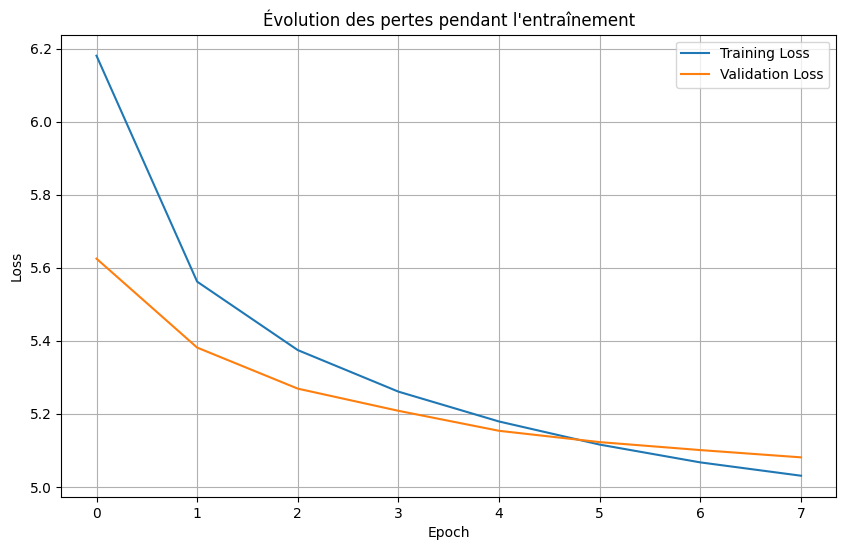

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Évolution des pertes pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
torch.save({
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    'model_config': {
        'vocab_size': tokenizer.vocab_size,
        'embedding_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'dropout': 0.3
    },
    'sequence_length': SEQUENCE_LENGTH
}, 'harry_potter_model.pth')

print("✅ Modèle sauvegardé dans 'harry_potter_model.pth'")

✅ Modèle sauvegardé dans 'harry_potter_model.pth'


In [19]:
def gradio_generate_text(start_word, max_length, temperature):
    """Fonction pour l'interface Gradio"""
    try:
        generated = generate_text(model, tokenizer, start_word, 
                                max_length=int(max_length), 
                                temperature=float(temperature))
        return generated
    except Exception as e:
        return f"Erreur: {str(e)}"

with gr.Blocks(title="🪄 Générateur Harry Potter") as demo:
    gr.HTML("""
    <h1 style="text-align: center;">🪄 Générateur de Texte Harry Potter</h1>
    <p style="text-align: center;">Entrez un mot et le modèle générera une suite dans le style Harry Potter!</p>
    """)
    
    with gr.Row():
        with gr.Column():
            start_word_input = gr.Textbox(
                label="Mot de départ",
                placeholder="Ex: harry, magic, wand, hogwarts...",
                value="harry"
            )
            
            max_length_slider = gr.Slider(
                minimum=5,
                maximum=100,
                value=30,
                step=5,
                label="Longueur maximale"
            )
            
            temperature_slider = gr.Slider(
                minimum=0.1,
                maximum=2.0,
                value=0.8,
                step=0.1,
                label="Créativité (température)"
            )
            
            generate_btn = gr.Button("🪄 Générer du texte", variant="primary")
        
        with gr.Column():
            output_text = gr.Textbox(
                label="Texte généré",
                lines=5,
                interactive=False
            )
    
    gr.Examples(
        examples=[
            ["harry", 25, 0.8],
            ["hermione", 30, 0.7],
            ["magic", 20, 1.0],
            ["wand", 35, 0.6],
            ["hogwarts", 40, 0.9]
        ],
        inputs=[start_word_input, max_length_slider, temperature_slider]
    )
    
    generate_btn.click(
        fn=gradio_generate_text,
        inputs=[start_word_input, max_length_slider, temperature_slider],
        outputs=output_text
    )
    
    gr.HTML("""
    <div style="text-align: center; margin-top: 20px;">
        <p><em>💡 Conseil: Une température basse (0.3-0.7) donne un texte plus cohérent, 
        une température haute (0.8-1.5) donne un texte plus créatif!</em></p>
    </div>
    """)

print("🚀 Lancement de l'interface Gradio...")
demo.launch(share=True, debug=True)

🚀 Lancement de l'interface Gradio...
* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Keyboard interruption in main thread... closing server.


In [20]:
def analyze_model_predictions(model, tokenizer, word, top_k=10):
    """Analyse les prédictions du modèle pour un mot donné"""
    model.eval()
    
    if word.lower() not in tokenizer.word_to_idx:
        print(f"Le mot '{word}' n'est pas dans le vocabulaire.")
        return
    
    sequence = [tokenizer.word_to_idx['<PAD>']] * (SEQUENCE_LENGTH - 1) + [tokenizer.word_to_idx[word.lower()]]
    input_seq = torch.tensor(sequence).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output, _ = model(input_seq)
        probabilities = torch.softmax(output, dim=1)
        
        top_probs, top_indices = torch.topk(probabilities, top_k)
        
        print(f"🔍 Top {top_k} mots prédits après '{word}':")
        for i in range(top_k):
            idx = top_indices[0][i].item()
            prob = top_probs[0][i].item()
            word_pred = tokenizer.idx_to_word[idx]
            print(f"{i+1:2d}. {word_pred:<15} ({prob:.1%})")

test_analysis_words = ['harry', 'magic', 'wand']
for word in test_analysis_words:
    analyze_model_predictions(model, tokenizer, word)
    print()

🔍 Top 10 mots prédits après 'harry':
 1. was             (7.3%)
 2. had             (6.3%)
 3. and             (3.5%)
 4. <UNK>           (3.4%)
 5. told            (3.3%)
 6. got             (3.0%)
 7. could           (2.8%)
 8. saw             (2.6%)
 9. knew            (2.3%)
10. thought         (2.1%)

🔍 Top 10 mots prédits après 'magic':
 1. -               (7.6%)
 2. <UNK>           (3.6%)
 3. .               (3.1%)
 4. is              (3.1%)
 5. was             (2.7%)
 6. can             (2.6%)
 7. and             (2.4%)
 8. has             (2.4%)
 9. would           (1.7%)
10. had             (1.4%)

🔍 Top 10 mots prédits après 'wand':
 1. <UNK>           (5.0%)
 2. -               (4.3%)
 3. was             (3.1%)
 4. is              (2.0%)
 5. had             (1.9%)
 6. and             (1.7%)
 7. .               (1.5%)
 8. "               (1.2%)
 9. has             (1.2%)
10. said            (1.0%)



In [21]:
def model_statistics():
    """Affiche des statistiques sur le modèle et les données"""
    print("📊 STATISTIQUES DU MODÈLE")
    print("=" * 50)
    
    print(f"📚 Taille du vocabulaire: {tokenizer.vocab_size:,} mots")
    print(f"📖 Longueur du corpus: {len(encoded_text):,} tokens")
    print(f"🔢 Séquences d'entraînement: {len(dataset):,}")
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🧠 Paramètres totaux: {total_params:,}")
    print(f"🏋️ Paramètres entraînables: {trainable_params:,}")
    
    model_size_mb = total_params * 4 / (1024 * 1024)
    print(f"💾 Taille estimée: {model_size_mb:.1f} MB")
    
    print(f"\n⚙️ Configuration:")
    print(f"   - Longueur de séquence: {SEQUENCE_LENGTH}")
    print(f"   - Taille de batch: {BATCH_SIZE}")
    print(f"   - Dimension embedding: 128")
    print(f"   - Dimension cachée: 256")
    print(f"   - Nombre de couches: 2")
    
    print(f"\n🎯 Device utilisé: {device}")

model_statistics()

📊 STATISTIQUES DU MODÈLE
📚 Taille du vocabulaire: 20,098 mots
📖 Longueur du corpus: 1,127,457 tokens
🔢 Séquences d'entraînement: 1,127,427

🧠 Paramètres totaux: 8,659,330
🏋️ Paramètres entraînables: 8,659,330
💾 Taille estimée: 33.0 MB

⚙️ Configuration:
   - Longueur de séquence: 30
   - Taille de batch: 64
   - Dimension embedding: 128
   - Dimension cachée: 256
   - Nombre de couches: 2

🎯 Device utilisé: cuda
